In [1]:
import numpy as np
import matplotlib.pyplot as plt

from data_handler import DataHandler, get_xy, zscore_data, apply_zscore
from calculations import Calculations

dh =  DataHandler("lfw20.csv")
data = dh.parse_data_no_header()
data = dh.shuffle_data(data)

X, y = get_xy(data)
X /= 255
means, stds = zscore_data(X)
X = apply_zscore(means, stds, X)

def PCA(data_, out_dimensions=2):
    m, D = data_.shape
    sigma = np.cov(data_, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    max_indices = get_max_val(eigenvectors, eigenvalues, out_dimensions)
    proj_data = np.dot(data_, eigenvectors[:, max_indices])
    projected_data_white = proj_data/np.sqrt(eigenvalues[max_indices].reshape((1, -1)))
    return proj_data, projected_data_white

def get_max_val(vectors, values, dimensions=2):
    max_vector_indices = np.argsort(values)
    return max_vector_indices[-dimensions:][::-1]

<h1>2. Dimensionality Reduction for Visualation</h1>

In [2]:
PCA_data, PCA_data_w = PCA(X)
PCA_data, PCA_data_w

(array([[-32.29422013+0.j, -18.16873789+0.j],
        [ 41.49459574+0.j,  25.70928511+0.j],
        [ 16.31304965+0.j,  -3.31504562+0.j],
        ...,
        [-54.31002679+0.j,   1.54567399+0.j],
        [ 41.39919296+0.j,   4.20011023+0.j],
        [ 93.27324069+0.j,  17.59222491+0.j]]),
 array([[-0.82825907+0.j, -0.73156563+0.j],
        [ 1.06422372+0.j,  1.03518634+0.j],
        [ 0.41838543+0.j, -0.13348057+0.j],
        ...,
        [-1.39290473+0.j,  0.06223668+0.j],
        [ 1.0617769 +0.j,  0.16911776+0.j],
        [ 2.39220538+0.j,  0.70835229+0.j]]))

/usr/bin/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


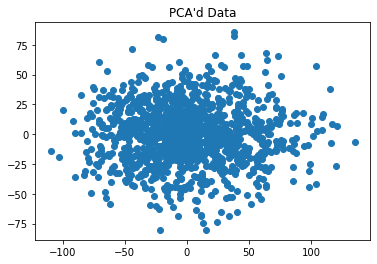

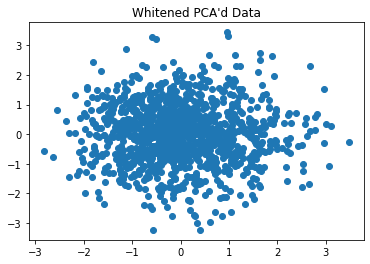

In [3]:
plt.title("PCA'd Data")
plt.scatter(PCA_data[:,0], PCA_data[:,1])
plt.show()
plt.title("Whitened PCA'd Data")
plt.scatter(PCA_data_w[:,0], PCA_data_w[:,1])
plt.show()

<h1>Dimensionality Reduction for KNNs</h1>

In [4]:
dh =  DataHandler("lfw20.csv")
data = dh.parse_data_no_header()
data = dh.shuffle_data(data)
data_train, data_test = dh.split_data(data)

#PCA Data Setup
K_X, K_y = get_xy(data)
K_X = apply_zscore(*zscore_data(K_X), K_X)
KNN_PCA, KNN_PCA_w = PCA(K_X, 100)
KNN_train, KNN_test = dh.split_data(KNN_PCA)
KNN_train_w, KNN_test_w = dh.split_data(KNN_PCA_w)

#Orig Data Setup
train_X, train_y = get_xy(data_train)
test_X, test_y = get_xy(data_test)
means, stds = zscore_data(train_X)
train_X = apply_zscore(means, stds, train_X)
test_X = apply_zscore(means, stds, test_X)

In [5]:
def KNN(testX, trainX, y_, K=1):
    testPreds = []
    for i in range(testX.shape[0]):
        distances = []
        test_x = testX[i]
        for j in range(trainX.shape[0]):
            distances.append(np.linalg.norm(test_x - trainX[j]))
        distances = np.array(distances)
        neighbor_y = train_y[np.argsort(distances)[:K]]
        unique_neighbors, counts = np.unique(neighbor_y, return_counts=True)
        y_pred = np.random.choice(neighbor_y)
        if counts.max() > 1:
            majority_vote = np.argmax(counts)
            y_pred = unique_neighbors[majority_vote]
        testPreds.append(y_pred)
    return np.array(testPreds)

In [6]:
y_hat = KNN(test_X, train_X, train_y)
np.mean(y_hat==test_y)

0.18932038834951456

In [7]:
y_hat = KNN(KNN_test, KNN_train, train_y)
np.mean(y_hat==test_y)

0.18689320388349515

In [8]:
y_hat = KNN(KNN_test_w, KNN_train_w, train_y)
np.mean(y_hat==test_y)

0.2621359223300971

In [9]:
PCA_data.shape

(1240, 2)